# Warning :
# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.


Avant de commencer le TP, vérifiez que vous êtes sur un environnement GPU et python 3 :

Exécution -> Modifier le type d'exécution -> Type d'exécution = python2, Accélerateur matériel = GPU

In [1]:
import argparse
import os
import time

import PIL
from PIL import Image

import numpy as np
import torchvision
import pickle

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable

from sklearn.svm import LinearSVC

# Partie 1 : Architecture VGG16

In [2]:
#!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/imagenet_classes.pkl
!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/imagenet_classes.pkl

# Bonus : Classifiez des exemples avec vgg16 et commentez le résultat dans votre rapport.
!wget --content-disposition https://unsplash.com/photos/gKXKBY-C-Dk/download?force=true -O cat.jpg
!wget --content-disposition https://unsplash.com/photos/qO-PIF84Vxg/download?force=true -O dog.jpg

--2023-12-28 13:45:52--  https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/imagenet_classes.pkl
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/imagenet_classes.pkl [following]
--2023-12-28 13:45:52--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/imagenet_classes.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35454 (35K) [text/plain]
Saving to: ‘imagenet_classes.pkl’

imagenet_classes.pk 100%[===================>]  34.62K  --.-KB/s    in 0.002s  

2023-12-28 13:45:52 (15.2 MB/s) - ‘imagenet_classes.pkl’ saved [35454

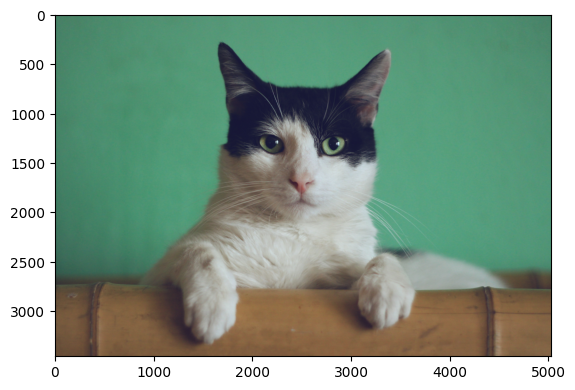

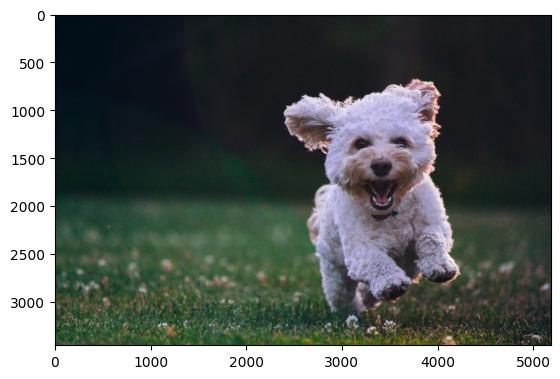

In [3]:
cat = Image.open('cat.jpg')
plt.imshow(cat)
plt.show()
dog = Image.open('dog.jpg')
plt.imshow(dog)
plt.show()

In [4]:
vgg16 = torchvision.models.vgg16(pretrained=True)
imagenet_classes = pickle.load(open('imagenet_classes.pkl', 'rb'))
def predict(name):
  img = Image.open(name)
  img = img.resize((224, 224))
  img = np.array(img, dtype=np.float32) / 255
  img = img.transpose((2, 0, 1))

  img = np.expand_dims(img, 0)
  x = torch.Tensor(img) # torch.Size([1, 3, 224, 224])

  transform = torchvision.transforms.Compose([
      transforms.Resize((224,224)),
      transforms.Normalize(
          mean = [0.485, 0.456, 0.406],
          std = [0.229, 0.224, 0.225])
  ])

  x = transform(x)
  y = vgg16(x).detach()
  y = y.numpy()
  max_y = np.argmax(y)
  score = y[0, max_y]

  print(f"The numbre {max_y} with the name of class {imagenet_classes[max_y]} and the score is {score}")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 75.8MB/s]


In [10]:
predict('cat.jpg')
predict('dog.jpg')

The numbre 285 with the name of class Egyptian cat and the score is 11.971183776855469
The numbre 189 with the name of class Lakeland terrier and the score is 12.40713882446289


In [11]:
from torchsummary import summary

summary(vgg16, (3, 224, 224), device = "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

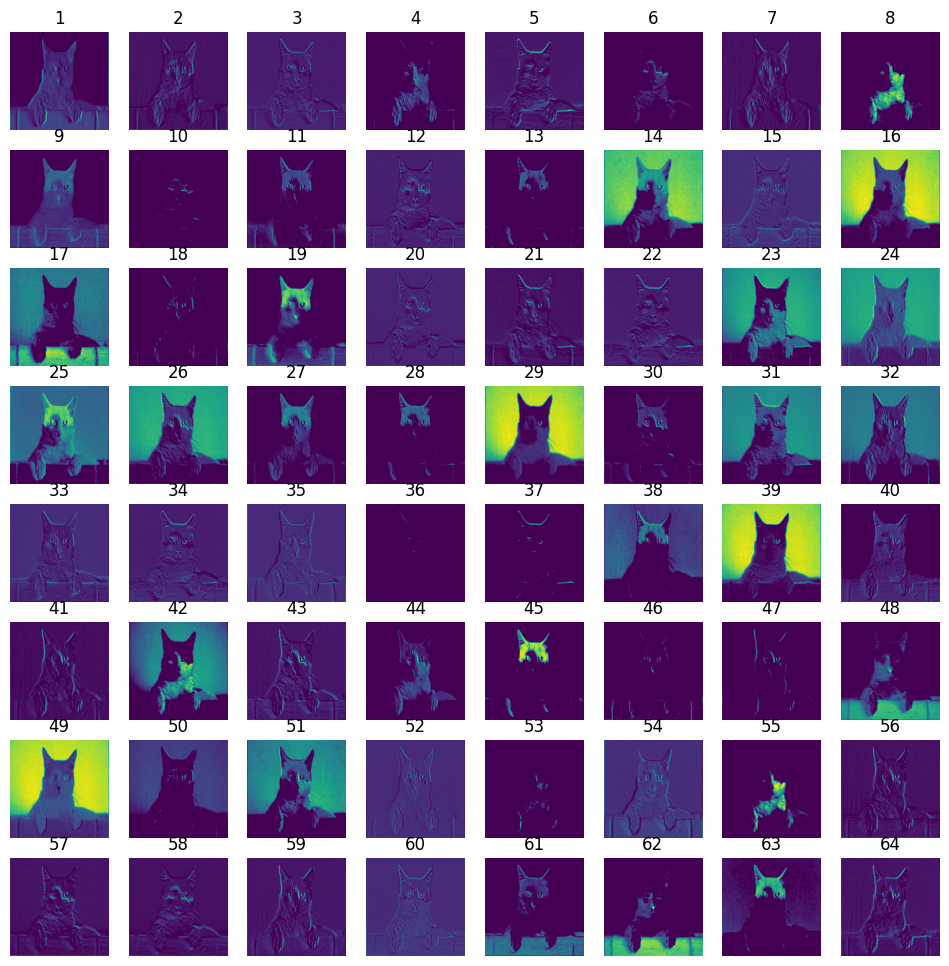

In [12]:
import matplotlib.pyplot as plt

vgg16 = torchvision.models.vgg16(pretrained=True)
imagenet_classes = pickle.load(open('imagenet_classes.pkl', 'rb'))
img = Image.open('cat.jpg')
img = img.resize((224, 224))
img = np.array(img, dtype=np.float32) / 255
img = img.transpose((2, 0, 1))
img = np.expand_dims(img, 0)
x = torch.Tensor(img) # torch.Size([1, 3, 224, 224])
transform = torchvision.transforms.Compose([
      transforms.Resize((224,224)),
      transforms.Normalize(
          mean = [0.485, 0.456, 0.406],
          std = [0.229, 0.224, 0.225])
])
x = transform(x)
y = vgg16(x).detach()
y = y.numpy()

first_conv_layer = vgg16.features[:2]
activation_maps = first_conv_layer(x).detach().numpy()

fig, axis = plt.subplots(8, 8, figsize=(12, 12))
for i in range(8):
  for j in range(8):
    axis[i,j].imshow(activation_maps[0, i * 8 + j, :, :], cmap='viridis')
    axis[i,j].axis('off')
    axis[i, j].set_title(f'{i * 8 + j + 1}')
plt.show()

# Partie 2: Transfer Learning avec VGG16 sur 15 Scene

In [13]:
#!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/15ScenesData.zip
!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/15ScenesData.zip

!unzip 15ScenesData.zip

--2023-12-28 13:47:09--  https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/15ScenesData.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/15ScenesData.zip [following]
--2023-12-28 13:47:09--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/15ScenesData.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86520868 (83M) [application/zip]
Saving to: ‘15ScenesData.zip’

15ScenesData.zip    100%[===================>]  82.51M   295MB/s    in 0.3s    

2023-12-28 13:47:11 (295 MB/s) - ‘15ScenesData.zip’ saved [86520868/86520868]

In [14]:
ls 15SceneData/test/bedroom/

image_0003.jpg  image_0035.jpg  image_0068.jpg  image_0103.jpg  image_0141.jpg  image_0182.jpg
image_0004.jpg  image_0037.jpg  image_0069.jpg  image_0104.jpg  image_0142.jpg  image_0189.jpg
image_0006.jpg  image_0039.jpg  image_0071.jpg  image_0112.jpg  image_0144.jpg  image_0190.jpg
image_0007.jpg  image_0040.jpg  image_0073.jpg  image_0113.jpg  image_0148.jpg  image_0191.jpg
image_0008.jpg  image_0042.jpg  image_0074.jpg  image_0114.jpg  image_0150.jpg  image_0192.jpg
image_0011.jpg  image_0043.jpg  image_0077.jpg  image_0115.jpg  image_0152.jpg  image_0195.jpg
image_0013.jpg  image_0047.jpg  image_0080.jpg  image_0117.jpg  image_0153.jpg  image_0196.jpg
image_0014.jpg  image_0049.jpg  image_0081.jpg  image_0118.jpg  image_0156.jpg  image_0200.jpg
image_0016.jpg  image_0050.jpg  image_0082.jpg  image_0119.jpg  image_0157.jpg  image_0202.jpg
image_0017.jpg  image_0052.jpg  image_0084.jpg  image_0120.jpg  image_0158.jpg  image_0203.jpg
image_0018.jpg  image_0053.jpg  image_0086.jpg  im

In [15]:
class VGG16relu7(nn.Module):
    def __init__(self):
      super(VGG16relu7, self).__init__()
      # Copy the entire convolutional part
      self.features = nn.Sequential( *list(vgg16.features.children()))
      # Keep a piece of the classifier: -2 to stop at relu7
      self.classifier = nn.Sequential(*list(vgg16.classifier.children())[:-2])
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [16]:
PRINT_INTERVAL = 50
CUDA = True

def get_dataset(batch_size, path):

    # Cette fonction permet de recopier 3 fois une image qui
    # ne serait que sur 1 channel (donc image niveau de gris)
    # pour la "transformer" en image RGB. Utilisez la avec
    # transform.Lambda
    def duplicateChannel(img):
        img = img.convert('L')
        np_img = np.array(img, dtype=np.uint8)
        np_img = np.dstack([np_img, np_img, np_img])
        img = Image.fromarray(np_img, 'RGB')
        return img

    #####################
    ## Votre code ici  ##
    #####################
    # Ajouter le pré-traitement
    train_dataset = datasets.ImageFolder(path+'/train',transform=torchvision.transforms.Compose([
            # Pré-traitement à faire
            transforms.Lambda(duplicateChannel),
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean = [0.485, 0.456, 0.406],
                std = [0.229, 0.224, 0.225])
        ]))

    val_dataset = datasets.ImageFolder(path+'/test',
        transform=transforms.Compose([
            # Pré-traitement à faire
            transforms.Lambda(duplicateChannel),
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean = [0.485, 0.456, 0.406],
                std = [0.229, 0.224, 0.225])
        ]))

    ####################
    ##      FIN        #
    ####################

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=2)

    return train_loader, val_loader

In [17]:
from sklearn.svm import LinearSVC

def extract_features(data, model):
    #####################
    ## Votre code ici  ##
    #####################
    # init features matrices
    X = None
    y = None
    ####################
    ##      FIN        #
    ####################

    for i, (input, target) in enumerate(data):
        if i % PRINT_INTERVAL == 0:
            print('Batch {0:03d}/{1:03d}'.format(i, len(data)))
        if CUDA:
            input = input.cuda()

        features = model(input).detach().cpu().numpy()
        features = features / np.linalg.norm(features, 2, 1, True)
        #####################
        ## Votre code ici  ##
        #####################
        # Feature extraction à faire

        if i == 0:
            X = features
            y = target.numpy()
        else:
            X = np.vstack((X, features))
            y = np.hstack((y, target.numpy()))

        ####################
        ##      FIN        #
        ####################


    return X, y


def main(path="15SceneData", batch_size=8):
    print('Instanciation de VGG16')
    vgg16 = models.vgg16(pretrained=True)

    print('Instanciation de VGG16relu7')
    #####################
    ## Votre code ici  ##
    #####################
    # Remplacer par le modèle par un réseau tronqué pour faire de la feature extraction
    # On créera une nouvelle classe VGG16relu7 ici
    #model = vgg16

    model = VGG16relu7()

    ####################
    ##      FIN        #
    ####################

    model.eval()
    if CUDA: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()

    # On récupère les données
    print('Récupération des données')
    train, test = get_dataset(batch_size, path)

    # Extraction des features
    print('Feature extraction')
    X_train, y_train = extract_features(train, model)
    X_test, y_test = extract_features(test, model)

    #####################
    ## Votre code ici  ##
    #####################
    # Apprentissage et évaluation des SVM à faire

    print('Apprentissage des SVM')
    accuracy = 0
    svm = LinearSVC(C=1.0)
    svm.fit(X_train, y_train)
    accuracy_train = svm.score(X_train, y_train)
    accuracy_test = svm.score(X_test, y_test)
    ####################
    ##      FIN        #
    ####################
    print('Accuracy of train = %f' % accuracy_train)
    print('Accuracy of test = %f' % accuracy_test)


In [18]:
main("15SceneData", 8)

Instanciation de VGG16
Instanciation de VGG16relu7
Récupération des données
Feature extraction
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
Apprentissage des SVM
Accuracy of train = 0.992000
Accuracy of test = 0.888107


#Patrie 3: Going further

### **1. Change the layer at which the features are extracted.**

In [19]:
list(vgg16.classifier.children())

[Linear(in_features=25088, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=1000, bias=True)]

In [20]:
list(vgg16.classifier.children())[:-2]

[Linear(in_features=25088, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=4096, bias=True),
 ReLU(inplace=True)]

In [21]:
list(vgg16.classifier.children())[:-5]

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True)]

In [22]:
class VGG16relu6(nn.Module):
  def __init__(self):
    super(VGG16relu6, self).__init__()
    # Copy the entire convolutional part
    self.features = nn.Sequential( *list(vgg16.features.children()))

    self.classifier = nn.Sequential(*list(vgg16.classifier.children())[:-5])

  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x

In [23]:
def main(path="15SceneData", batch_size=8):
    print('Instanciation de VGG16')
    vgg16 = models.vgg16(pretrained=True)

    print('Instanciation de VGG16relu7')
    #####################
    ## Votre code ici  ##
    #####################
    # Remplacer par le modèle par un réseau tronqué pour faire de la feature extraction
    # On créera une nouvelle classe VGG16relu7 ici
    #model = vgg16

    model = VGG16relu6()

    ####################
    ##      FIN        #
    ####################

    model.eval()
    if CUDA: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()

    # On récupère les données
    print('Récupération des données')
    train, test = get_dataset(batch_size, path)

    # Extraction des features
    print('Feature extraction')
    X_train, y_train = extract_features(train, model)
    X_test, y_test = extract_features(test, model)

    #####################
    ## Votre code ici  ##
    #####################
    # Apprentissage et évaluation des SVM à faire

    print('Apprentissage des SVM')
    accuracy = 0
    svm = LinearSVC(C=1.0)
    svm.fit(X_train, y_train)
    accuracy_train = svm.score(X_train, y_train)
    accuracy_test = svm.score(X_test, y_test)
    ####################
    ##      FIN        #
    ####################
    print('Accuracy of train = %f' % accuracy_train)
    print('Accuracy of test = %f' % accuracy_test)


In [24]:
main("15SceneData", 8)

Instanciation de VGG16


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Instanciation de VGG16relu7
Récupération des données
Feature extraction
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
Apprentissage des SVM
Accuracy of train = 0.998000
Accuracy of test = 0.906868


### **2. Try other available pre-trained networks.**


---

**Here, I use the AlexNet.**






In [25]:
alexnet = models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 158MB/s]


In [26]:
list(alexnet.children())

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
   (1): ReLU(inplace=True)
   (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
   (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
   (4): ReLU(inplace=True)
   (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
   (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (7): ReLU(inplace=True)
   (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (9): ReLU(inplace=True)
   (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (11): ReLU(inplace=True)
   (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
 ),
 AdaptiveAvgPool2d(output_size=(6, 6)),
 Sequential(
   (0): Dropout(p=0.5, inplace=False)
   (1): Linear(in_features=9216, out_features=4096, bias=True)
   (2): ReLU(inplace=True)
   (3): Dropout(p=0.5, inplace=False)

In [27]:
class AlexNetrelu7(nn.Module):
  def __init__(self):
    super(AlexNetrelu7, self).__init__()
    # Copy the entire convolutional part
    self.features = nn.Sequential( *list(alexnet.features.children()))

    self.classifier = nn.Sequential(*list(alexnet.classifier.children())[:-2])

  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x

In [28]:
def main_alexnet(path="15SceneData", batch_size=8):
    print('Instanciation de AlexNet')
    alexnet = models.alexnet(pretrained=True)

    print('Instanciation de AlexNetrelu7')
    #####################
    ## Votre code ici  ##
    #####################
    # Remplacer par le modèle par un réseau tronqué pour faire de la feature extraction
    model = AlexNetrelu7()

    ####################
    ##      FIN        #
    ####################

    model.eval()
    if CUDA: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()

    # On récupère les données
    print('Récupération des données')
    train, test = get_dataset(batch_size, path)

    # Extraction des features
    print('Feature extraction')
    X_train, y_train = extract_features(train, model)
    X_test, y_test = extract_features(test, model)
    # Normalisation l2
    X_train = torch.from_numpy(X_train)
    X_test = torch.from_numpy(X_test)
    X_train = nn.functional.normalize(X_train, p=2, dim=1)
    X_test = nn.functional.normalize(X_test, p=2, dim=1)

    #####################
    ## Votre code ici  ##
    #####################
    # Apprentissage et évaluation des SVM à faire
    print('Apprentissage des SVM')
    svm_classifier = LinearSVC(C=1, max_iter=5000)
    svm_classifier.fit(X_train, y_train)

    y_pred_train = svm_classifier.predict(X_train)
    y_pred_test = svm_classifier.predict(X_test)

    accuracy = 0
    accuracy_train = svm_classifier.score(X_train, y_train)
    accuracy_test = svm_classifier.score(X_test, y_test)

    ####################
    ##      FIN        #
    ####################
    print('Accuracy train = %f' % accuracy_train)
    print('Accuracy test = %f' % accuracy_test)

In [29]:
main_alexnet("15SceneData", 8)

Instanciation de AlexNet
Instanciation de AlexNetrelu7
Récupération des données
Feature extraction
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
Apprentissage des SVM
Accuracy train = 0.930667
Accuracy test = 0.868342


### **3. Tune the parameter C**


---

**Here, for C, I try in [0.01, 0.1, 1, 10, 50].**



In [30]:
class VGG16relu7(nn.Module):
  def __init__(self):
    super(VGG16relu7, self).__init__()
    self.features = nn.Sequential( *list(vgg16.features.children()))
    self.classifier = nn.Sequential(*list(vgg16.classifier.children())[:-2])

  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x

In [33]:
def mainC(path="15SceneData", batch_size=8):
    print('Instanciation de VGG16')
    vgg16 = models.vgg16(pretrained=True)

    print('Instanciation de VGG16relu7')
    #####################
    ## Votre code ici  ##
    #####################
    # Remplacer par le modèle par un réseau tronqué pour faire de la feature extraction
    # On créera une nouvelle classe VGG16relu7 ici
    #model = vgg16
    model = VGG16relu7()
    ####################
    ##      FIN        #
    ####################

    model.eval()
    if CUDA: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()

    # On récupère les données
    print('Récupération des données')
    train, test = get_dataset(batch_size, path)

    # Extraction des features
    print('Feature extraction')
    X_train, y_train = extract_features(train, model)
    X_test, y_test = extract_features(test, model)

    #####################
    ## Votre code ici  ##
    #####################
    # Apprentissage et évaluation des SVM à faire

    print('Apprentissage des SVM')
    accuracy = 0
    liste_C = [0.01, 0.1, 1, 10, 50]
    for c in liste_C:
        print("C is ", c)
        svm = LinearSVC(C = c)
        svm.fit(X_train, y_train)
        accuracy_train = svm.score(X_train, y_train)
        accuracy_test = svm.score(X_test, y_test)
    ####################
    ##      FIN        #
    ####################
        print('Accuracy of train = %f' % accuracy_train)
        print('Accuracy of test = %f' % accuracy_test)


In [34]:
mainC("15SceneData", 8)

Instanciation de VGG16


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Instanciation de VGG16relu7
Récupération des données
Feature extraction
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
Apprentissage des SVM
C is  0.01
Accuracy of train = 0.876000
Accuracy of test = 0.841206
C is  0.1
Accuracy of train = 0.930667
Accuracy of test = 0.873367
C is  1
Accuracy of train = 0.992000
Accuracy of test = 0.888107
C is  10
Accuracy of train = 1.000000
Accuracy of test = 0.886097
C is  50
Accuracy of train = 1.000000
Accuracy of test = 0.884087


###**4. Instead of training an SVM, replace the last layer of VGG16 with a new fully-connected layer and continue to train the network on 15 Scene (with or without propogating the gradients to the rest of the network).**

In [48]:
import torch.nn.functional as F
import torch.optim as optim

class VGG16new(nn.Module):
    def __init__(self, num_classes):
        super(VGG16new, self).__init__()
        vgg16 = models.vgg16(pretrained=True)

        self.features = vgg16.features
        nb_features = vgg16.classifier[-1].in_features
        self.classifier = nn.Sequential(
            *list(vgg16.classifier.children())[:-1],
            nn.Linear(nb_features, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [51]:
def main_new(path="15SceneData", batch_size=8):
    print('Instanciation de VGG16relu7')

    model = VGG16new(num_classes=15)

    model.train()
    if CUDA:
        cudnn.benchmark = True
        model = model.cuda()

    print('Récupération des données')
    train, test = get_dataset(batch_size, path)

    # SGD and CrossEntropyLoss
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    # 15 Scene dataset
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])
    ])

    train_dataset = datasets.ImageFolder(root=path, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # train new model
    num_epochs = 5
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct_predictions = 0
        total_samples = 0
        for inputs, labels in train_loader:
            if CUDA:
                inputs, labels = inputs.cuda(), labels.cuda()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        average_loss = total_loss / len(train_loader)
        accuracy = correct_predictions / total_samples

        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Accuracy: {accuracy}')


main_new()


Instanciation de VGG16relu7
Récupération des données
Epoch 1/5, Loss: 0.5803447961807251, Accuracy: 0.61917502787068
Epoch 2/5, Loss: 0.48304033279418945, Accuracy: 0.6470457079152732
Epoch 3/5, Loss: 0.9023851156234741, Accuracy: 0.6633221850613155
Epoch 4/5, Loss: 0.6322656869888306, Accuracy: 0.6809364548494983
Epoch 5/5, Loss: 0.8598133325576782, Accuracy: 0.7186176142697882


### **5. Look into methods for dimensionality reduction before classification and their impact on performance and execution time.**

In [59]:
class VGG16Reduction(nn.Module):
  def __init__(self):
    super(VGG16Reduction, self).__init__()
    self.features = nn.Sequential(*list(vgg16.features.children()))
    self.classifier = nn.Sequential(*list(vgg16.classifier.children())[:-2])

  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x

In [66]:
import time
from sklearn.decomposition import PCA

def main_reduction(path="15SceneData", batch_size=8, pca_components=None):
    print('Instanciation de VGG16')
    vgg16 = models.vgg16(pretrained=True)

    print('Instanciation de VGG16relu7')
    #####################
    ## Votre code ici  ##
    #####################
    # Remplacer par le modèle par un réseau tronqué pour faire de la feature extraction
    # On créera une nouvelle classe VGG16relu7 ici
    #model = vgg16
    model = VGG16Reduction()
    ####################
    ##      FIN        #
    ####################

    model.eval()
    if CUDA: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()

    # On récupère les données
    print('Récupération des données')
    train, test = get_dataset(batch_size, path)

    # Extraction des features
    print('Feature extraction')
    if pca_components:
        pca = PCA(pca_components)
        X_train, y_train = extract_features(train, model)
        X_train = pca.fit_transform(X_train)
        X_test, y_test = extract_features(test, model)
        X_test = pca.transform(X_test)
    else:
        X_train, y_train = extract_features(train, model)
        X_test, y_test = extract_features(test, model)

    #####################
    ## Votre code ici  ##
    #####################
    # Apprentissage et évaluation des SVM à faire

    start_time = time.time()

    print('Apprentissage des SVM')
    svm = LinearSVC(C = 1)
    svm.fit(X_train, y_train)
    accuracy_train = svm.score(X_train, y_train)
    accuracy_test = svm.score(X_test, y_test)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'Training and evaluation time: {elapsed_time} seconds')

    ####################
    ##      FIN        #
    ####################
    print('Accuracy of train = %f' % accuracy_train)
    print('Accuracy of test = %f' % accuracy_test)

In [67]:
main_reduction(path="15SceneData", batch_size=8, pca_components= 0.9)

Instanciation de VGG16


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Instanciation de VGG16relu7
Récupération des données
Feature extraction
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
Apprentissage des SVM
Training and evaluation time: 0.3792405128479004 seconds
Accuracy of train = 0.976667
Accuracy of test = 0.888107


In [68]:
main_reduction(path="15SceneData", batch_size=8)

Instanciation de VGG16


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Instanciation de VGG16relu7
Récupération des données
Feature extraction
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
Apprentissage des SVM
Training and evaluation time: 0.7710793018341064 seconds
Accuracy of train = 0.992000
Accuracy of test = 0.888107
